In [14]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime

PARENT_DIR = "/Users/emmawaters/Desktop/Dance/Prod/"
NUM_PARTS = 15
NUM_CHUNKS = 1

song_list = ['Aurora', 'Aphex', 'Armatrading', 'Tnertle', 'Willow', 'Jiggle']
song_shortlist = ['Tnertle', 'Willow', 'Jiggle']
dancer_list = ['Dorissa', 'Dot', 'Falcon', 'Imogen', 'Lia', 'Sophia', 'Sunny']

In [16]:
# INITIALIZE MASTER DATAFRAME
data_init = {
    'song' : [song for song in song_list for i in range(7)],
    'dancer': dancer_list * 6 
}

df = pd.DataFrame(data_init)
print(df)

           song   dancer
0        Aurora  Dorissa
1        Aurora      Dot
2        Aurora   Falcon
3        Aurora   Imogen
4        Aurora      Lia
5        Aurora   Sophia
6        Aurora    Sunny
7         Aphex  Dorissa
8         Aphex      Dot
9         Aphex   Falcon
10        Aphex   Imogen
11        Aphex      Lia
12        Aphex   Sophia
13        Aphex    Sunny
14  Armatrading  Dorissa
15  Armatrading      Dot
16  Armatrading   Falcon
17  Armatrading   Imogen
18  Armatrading      Lia
19  Armatrading   Sophia
20  Armatrading    Sunny
21      Tnertle  Dorissa
22      Tnertle      Dot
23      Tnertle   Falcon
24      Tnertle   Imogen
25      Tnertle      Lia
26      Tnertle   Sophia
27      Tnertle    Sunny
28       Willow  Dorissa
29       Willow      Dot
30       Willow   Falcon
31       Willow   Imogen
32       Willow      Lia
33       Willow   Sophia
34       Willow    Sunny
35       Jiggle  Dorissa
36       Jiggle      Dot
37       Jiggle   Falcon
38       Jiggle   Imogen


In [ ]:
# ---------------------------------------------------------------------- Processing Videos --------

In [17]:
# read_video_to_movement() returns the list of joint positions found using openCV
# Also returns a count of the number of joints not found, to be used to measure accuracy
def read_video_to_movement(vidpath):
    data = []
    net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
    cap = cv.VideoCapture(vidpath)

    BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                   "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                   "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "Background": 14 }

    POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                   ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                   ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                   ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"] ]

    error = 0
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            break

        #frame = cv.rotate(frame, cv.ROTATE_180) #ONLY needed if raw iPhone data
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        net.setInput(cv.dnn.blobFromImage(frame, 1.0, (368, 368), (127.5, 127.5, 127.5), swapRB=True, crop=False))
        out = net.forward()
        out = out[:, :15, :, :]

        assert(len(BODY_PARTS) == out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            heatMap = out[0, i, :, :]
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]
            if conf > 0.1:
                points.append(np.array([x, y]))
            else:
                points.append(np.array([None,None]))
                error += 1

        data.append(points)
    return (data, error)

In [21]:
# COLLECT RAW MOTION TRACKING DATA AND COLLECT ERRORS
FRAMES_BY_SONG = {}

raw_dance_data_1 = []
errors_1 = []

raw_dance_data_2 = []
errors_2 = []

raw_dance_data_3 = []
errors_3 = []

time_start = datetime.datetime.now()

for song in song_list:
    print(song) # To monitor progress
    num_frames = float('inf')
    
    for dancer in dancer_list:
        print(dancer) # To monitor progress
        
        # Use OpenPose
        (movement_1, error_1) = read_video_to_movement(os.path.join(PARENT_DIR, dancer + '_' + song +'_1.mp4'))
        if song in song_shortlist:
            (movement_2, error_2) = read_video_to_movement(os.path.join(PARENT_DIR, dancer + '_' + song +'_2.mp4'))
            (movement_3, error_3) = read_video_to_movement(os.path.join(PARENT_DIR, dancer + '_' + song +'_3.mp4'))
        else:
            (movement_2, error_2) = (None, None)
            (movement_3, error_3) = (None, None)
        
        # Record percent of joints missed
        errors_1.append(error_1/(len(movement_1)*NUM_PARTS))
        if song in song_shortlist:
            errors_2.append(error_2/(len(movement_2)*NUM_PARTS))
            errors_3.append(error_3/(len(movement_3)*NUM_PARTS))
        else:
            errors_2.append(None)
            errors_3.append(None)
        
        # Record raw movement data
        raw_dance_data_1.append(movement_1)
        raw_dance_data_2.append(movement_2)
        raw_dance_data_3.append(movement_3)
        
        # Keep track of shortest video, so that we don't cause indexing issues when comparing
        if song in song_shortlist:
            min_frames = min( [len(movement_1), len(movement_2), len(movement_3)] )
        else:
            min_frames = len(movement_1)
            
        if min_frames < num_frames:
            num_frames = min_frames
    
    FRAMES_BY_SONG[song] = num_frames

# Print run time of video processing
time_end = datetime.datetime.now()
print("Time to process videos: " + str(time_end-time_start))

# Add (correctly ordered) raw movement lists to DataFrame
df['raw_dance_1'] = raw_dance_data_1
df['raw_dance_2'] = raw_dance_data_2
df['raw_dance_3'] = raw_dance_data_3

df['errors_1'] = errors_1
df['errors_2'] = errors_2
df['errors_3'] = errors_3

Aurora
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Aphex
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Armatrading
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Tnertle
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Willow
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Jiggle
Dorissa
Dot
Falcon
Imogen
Lia
Sophia
Sunny
Time to process videos: 1:40:19.699254


In [22]:
# vectorize_movement() returns a vector representing the consolidated characteristics of the raw movement data
def vectorize_movement(movement, num_chunks, NUM_PARTS, NUM_FRAMES):
    move_vec = []
    chunk_size = int(NUM_FRAMES/num_chunks)
    for n in range(num_chunks):
        for joint in range(NUM_PARTS):
            x_pos_disp = 0
            x_neg_disp = 0
            y_pos_disp = 0
            y_neg_disp = 0
            
            for i in range(chunk_size):
                if (n*chunk_size + i + 1 >= len(movement)):
                    break
                prev_frame = movement[n*chunk_size + i]
                frame = movement[n*chunk_size + i + 1]

                if prev_frame[joint].all() and frame[joint].all():
                    disp = prev_frame[joint] - frame[joint]

                    if disp[0] > 0:
                        x_pos_disp += disp[0]
                    else:
                        x_neg_disp += disp[0]
                    if disp[1] > 0:
                        y_pos_disp += disp[1]
                    else:
                        y_neg_disp += disp[1]
            move_vec += [x_pos_disp, x_neg_disp, y_pos_disp, y_neg_disp]
    return move_vec

In [27]:
# COMPUTE CHARACTERISTIC VECTORS PER DANCE
time_start = datetime.datetime.now()

characteristic_vectors_1 = []
characteristic_vectors_2 = []
characteristic_vectors_3 = []

for i in range(df.shape[0]):
    song = df['song'][i]
    
    raw_motion_1 = df['raw_dance_1'][i]
    raw_motion_2 = df['raw_dance_2'][i]
    raw_motion_3 = df['raw_dance_3'][i]
    
    move_vec_1 = vectorize_movement(raw_motion_1, NUM_CHUNKS, NUM_PARTS, FRAMES_BY_SONG[song])
    characteristic_vectors_1.append(np.array(move_vec_1))
    if song in song_shortlist:
        move_vec_2 = vectorize_movement(raw_motion_2, NUM_CHUNKS, NUM_PARTS, FRAMES_BY_SONG[song])
        move_vec_3 = vectorize_movement(raw_motion_3, NUM_CHUNKS, NUM_PARTS, FRAMES_BY_SONG[song])
        characteristic_vectors_2.append(np.array(move_vec_2))
        characteristic_vectors_3.append(np.array(move_vec_3))
    else:
        characteristic_vectors_2.append(None)
        characteristic_vectors_3.append(None)
        
        
df['char_vecs_1'] = characteristic_vectors_1
df['char_vecs_2'] = characteristic_vectors_2
df['char_vecs_3'] = characteristic_vectors_3

time_end = datetime.datetime.now()
print("Time to vectorize movements: " + str(time_end-time_start))

df.tail()

Time to vectorize movements: 0:00:05.059708


,song,dancer,raw_dance_1,raw_dance_2,raw_dance_3,errors_1,errors_2,errors_3,char_vecs_1,char_vecs_2,char_vecs_3
37,Jiggle,Falcon,"[[[918.2608695652174, 305.2173913043478], [918...","[[[None, None], [960.0, 469.5652173913044], [9...","[[[None, None], [834.7826086956521, 516.521739...",0.191527,0.184422,0.651123,"[292.1739130434778, -250.4347826086953, 234.78...","[208.69565217391312, -417.3913043478261, 211.3...","[41.73913043478262, -83.47826086956525, 93.913..."
38,Jiggle,Imogen,"[[[793.0434782608696, 258.2608695652174], [751...","[[[None, None], [834.7826086956521, 328.695652...","[[[None, None], [834.7826086956521, 375.652173...",0.108069,0.076799,0.341008,"[960.0, -960.0000000000002, 1197.3913043478265...","[542.6086956521739, -417.391304347826, 399.130...","[459.1304347826085, -333.91304347826076, 563.4..."
39,Jiggle,Lia,"[[[834.7826086956521, 328.69565217391306], [83...","[[[918.2608695652174, 258.2608695652174], [918...","[[[None, None], [None, None], [None, None], [N...",0.022072,0.048237,0.500867,"[1252.1739130434776, -1210.434782608695, 751.3...","[1126.95652173913, -1085.2173913043475, 727.82...","[166.9565217391305, -208.69565217391312, 258.2..."
40,Jiggle,Sophia,"[[[1001.7391304347826, 352.17391304347825], [1...","[[[1001.7391304347826, 258.2608695652174], [10...","[[[918.2608695652174, 305.2173913043478], [918...",0.068004,0.291723,0.141030,"[1794.7826086956518, -1794.782608695652, 1995....","[500.8695652173915, -417.39130434782624, 305.2...","[751.3043478260871, -667.8260869565219, 352.17..."
41,Jiggle,Sunny,"[[[834.7826086956521, 281.7391304347826], [793...","[[[960.0, 234.7826086956522], [1001.7391304347...","[[[918.2608695652174, 258.2608695652174], [918...",0.006164,0.049570,0.092096,"[1836.5217391304327, -2003.4782608695623, 1103...","[1753.0434782608686, -1544.3478260869558, 633....","[751.3043478260872, -793.0434782608698, 633.91..."


In [28]:
# ----------------------------------------------------------------------- Running PCA --------

In [131]:
def generate_X(song):
    song_df = df.loc[df['song'] == song]
    char_vec_set = song_df['char_vecs_1']
    move_vec_list = []
    for char_vec in char_vec_set:
        move_vec_list.append(char_vec)
    X = np.array(move_vec_list)
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled

def show_scree(song, X):
    pca_7comp = PCA(n_components=7)
    pca_7fit = pca_7comp.fit(X)
    
    plt.figure(figsize=(3,3))
    plt.bar(
        range(1,len(pca_7comp.explained_variance_ratio_)+1),
        pca_7comp.explained_variance_ratio_
        )
    plt.xlabel('PCA Feature')
    plt.ylabel('Explained variance')
    plt.title('Feature Explained Variance ' + song)
    plt.show()
    print(pca_7comp.explained_variance_ratio_)

def show_pca_2plot(song, X):
    pca_2comp = PCA(n_components=2)
    pca_2fit = pca_2comp.fit_transform(X)
    
    pca_df = pd.DataFrame(data=pca_2fit, columns=['PC1', 'PC2'])
    pca_df['target'] = ['Dorissa', 'Dot', 'Falcon', 'Imogen', 'Lia', 'Sophia', 'Sunny']
    
    sns.set()
    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=pca_df, 
        hue='target', 
        fit_reg=False, 
        legend=True
        )

    plt.title(song)
    plt.show()
    return pca_2fit

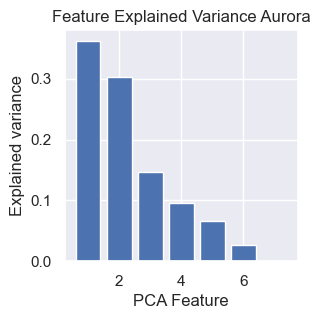

[3.61473877e-01 3.03085073e-01 1.46517224e-01 9.58815942e-02
 6.65953918e-02 2.64468403e-02 1.41338019e-32]


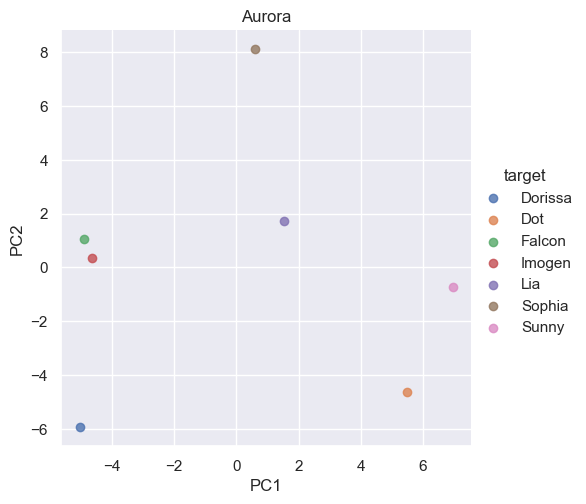

[[-5.03062737 -5.93846613]
 [ 5.49601504 -4.61904233]
 [-4.88115365  1.05890337]
 [-4.64198391  0.37032803]
 [ 1.5242198   1.72656348]
 [ 0.58622451  8.12028412]
 [ 6.94730558 -0.71857054]]


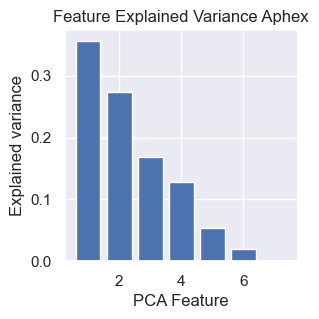

[3.55814886e-01 2.72978126e-01 1.68964114e-01 1.28570863e-01
 5.39136690e-02 1.97583415e-02 6.90776612e-33]


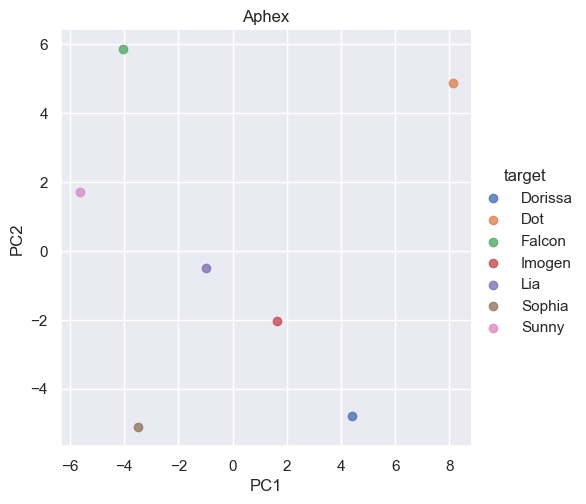

[[ 4.41595565 -4.80050599]
 [ 8.11509763  4.8669497 ]
 [-4.05137021  5.86753199]
 [ 1.63525493 -2.02312952]
 [-0.97709033 -0.49326762]
 [-3.49787677 -5.12306348]
 [-5.6399709   1.70548493]]


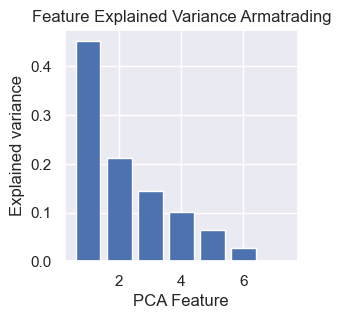

[4.51857850e-01 2.11802332e-01 1.44675951e-01 1.00917511e-01
 6.40483474e-02 2.66980095e-02 1.74320607e-32]


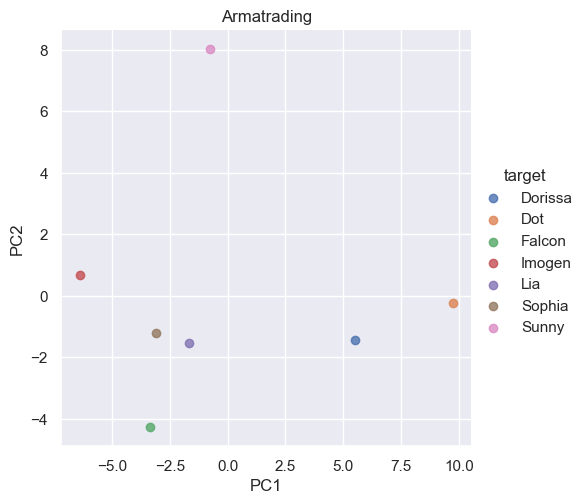

[[ 5.51729583 -1.44960775]
 [ 9.71743345 -0.24441583]
 [-3.36920347 -4.27056322]
 [-6.38490056  0.66359795]
 [-1.65042409 -1.52555293]
 [-3.08420783 -1.19594038]
 [-0.74599332  8.02248216]]


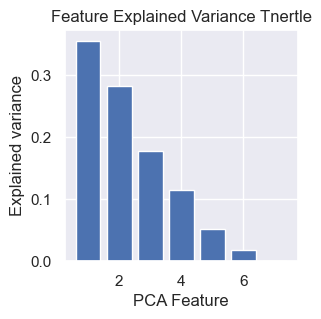

[3.54197262e-01 2.82047185e-01 1.78213623e-01 1.15303617e-01
 5.25327278e-02 1.77055844e-02 7.52627240e-33]


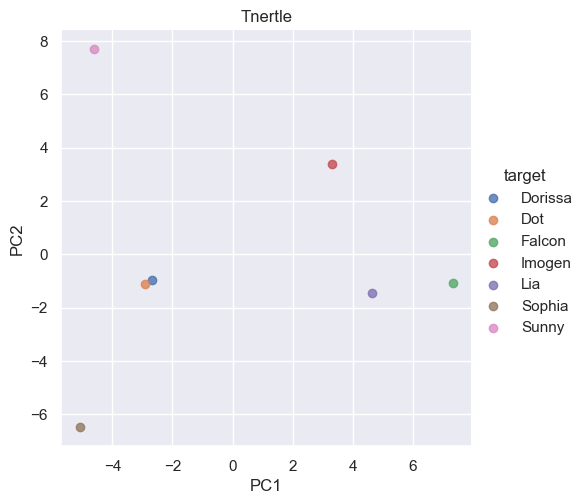

[[-2.67442134 -0.9595522 ]
 [-2.90939896 -1.11852687]
 [ 7.32573537 -1.06537784]
 [ 3.300456    3.39663706]
 [ 4.64336468 -1.46641277]
 [-5.08652319 -6.49019525]
 [-4.59921256  7.70342788]]


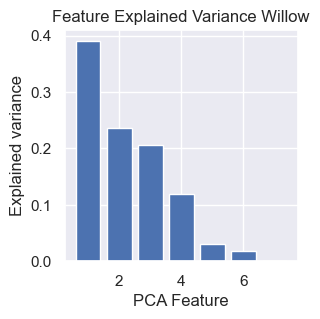

[3.90154990e-01 2.36894139e-01 2.05911645e-01 1.19073402e-01
 2.97097998e-02 1.82560240e-02 5.51136478e-33]


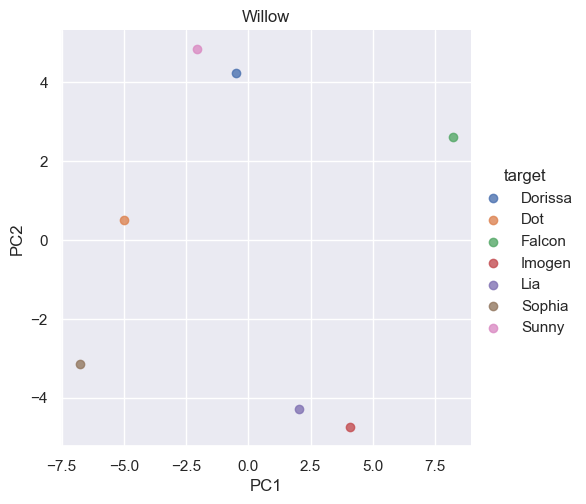

[[-0.47886361  4.22684419]
 [-5.01441982  0.50794881]
 [ 8.20642902  2.62148943]
 [ 4.09384103 -4.75425145]
 [ 2.04541465 -4.29329742]
 [-6.77355474 -3.15646667]
 [-2.07884653  4.84773312]]


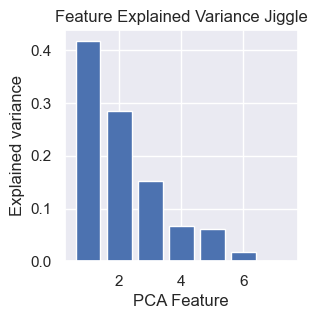

[4.17372629e-01 2.85729847e-01 1.52507425e-01 6.66853609e-02
 6.09619331e-02 1.67428057e-02 1.76842860e-32]


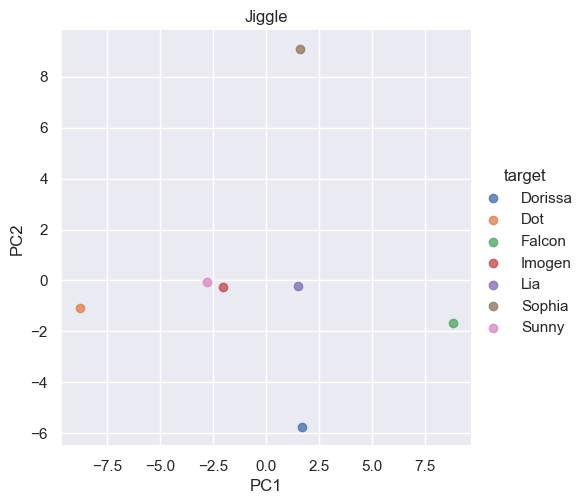

[[ 1.71898071 -5.76483307]
 [-8.80587698 -1.09902224]
 [ 8.82244783 -1.68392699]
 [-2.05099635 -0.26019634]
 [ 1.49955303 -0.22717473]
 [ 1.62224631  9.08887117]
 [-2.80635456 -0.0537178 ]]


,song,dancer,raw_dance_1,raw_dance_2,raw_dance_3,errors_1,errors_2,errors_3,char_vecs_1,char_vecs_2,char_vecs_3,fit
0,Aurora,Dorissa,"[[[918.2608695652174, 258.2608695652174], [834...",None,None,0.107699,NaN,NaN,"[2337.391304347824, -2546.0869565217367, 1502....",None,None,"[-5.0306273713895715, -5.93846612880068]"
1,Aurora,Dot,"[[[1001.7391304347826, 211.30434782608697], [1...",None,None,0.054742,NaN,NaN,"[3923.4782608695664, -3589.5652173913036, 2629...",None,None,"[5.496015039724692, -4.619042327724231]"
2,Aurora,Falcon,"[[[960.0, 211.30434782608697], [1043.478260869...",None,None,0.148211,NaN,NaN,"[1627.826086956522, -1794.7826086956516, 1620....",None,None,"[-4.881153645572241, 1.0589033658376514]"
3,Aurora,Imogen,"[[[None, None], [918.2608695652174, 375.652173...",None,None,0.184485,NaN,NaN,"[1836.5217391304336, -1794.782608695651, 1573....",None,None,"[-4.641983905252189, 0.3703280344042131]"
4,Aurora,Lia,"[[[None, None], [793.0434782608696, 258.260869...",None,None,0.162538,NaN,NaN,"[1878.2608695652161, -1753.0434782608681, 2206...",None,None,"[1.5242197993509359, 1.7265634794175908]"


In [132]:
fit_list = []
# GENERATE PCA TABLES & PLOTS
for song in song_list:
    X = generate_X(song)
    show_scree(song, X)
    fit = show_pca_2plot(song, X)
    print(fit)
    
    for point in fit:
        fit_list.append(np.array(point))
    
df['fit'] = fit_list
df.head()

In [33]:
# -------------------------------------------------------------------- PCA Validation --------

In [133]:
# make_dist_dict() creates a dictionary with a key per dancer.
# For each dancer key, the value is a list ordering the dancers 
# according to their distance to the location of the key (increasing).
# The key will be the first dancer in the list, as the distance to themselves is zero.
def make_dist_dict(names, points):
    dist_dict = {}
    for dancer in range(len(names)):
        distances = []
        for comp in range(len(names)):
            dist = np.sqrt(np.sum(np.square(points[dancer] - points[comp])))
            distances.append((dist, names[comp]))
        distances.sort()
        dist_dict[names[dancer]] = [x[1] for x in distances]
    return dist_dict

# levenshtein_distance() returns an integer representing the number of list-edits 
# (insertion, deletion, substitution) required to transform list1 into list2
# ~ Implementation from "https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/"
def levenshtein_distance(list1, list2):
    distances = np.zeros((len(list1) + 1, len(list2) + 1))

    for t1 in range(len(list1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(list2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(list1) + 1):
        for t2 in range(1, len(list2) + 1):
            if (list1[t1-1] == list2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(list1)][len(list2)]
    

# compare_dist_dicts() returns a dictionary of the modified Levenshtein distance between each
# list in the two given dictionaries
def compare_dist_dicts(char_dict, pca_dict):
    levenshtein_dict = {}
    for dancer in dancer_list:
        levenshtein_dict[dancer] = levenshtein_distance(char_dict[dancer], pca_dict[dancer])
    return levenshtein_dict
    

# For each song, generate a distance dictionary 
# for both the set of characteristic vectors (in R^60) and the fit vectors (in R^2).
# Compare.
for song in song_list:
    song_df = df.loc[df['song'] == song]
    
    # Generate distance dictionary in the characteristic vector space
    char_vec_set = song_df['char_vecs_1'].values
    char_vec_dist_dict = make_dist_dict(dancer_list, char_vec_set)
    
    # Generate distance dictionary in the staging space
    pca_points = song_df['fit'].values
    pca_dist_dict = make_dist_dict(dancer_list, pca_points)
    
    # Print dictionaries of Levenshtein distances
    print(song + ": ")
    print(compare_dist_dicts(char_vec_dist_dict, pca_dist_dict))
    print()

Aurora: 
{'Dorissa': 2.0, 'Dot': 4.0, 'Falcon': 2.0, 'Imogen': 4.0, 'Lia': 4.0, 'Sophia': 3.0, 'Sunny': 2.0}

Aphex: 
{'Dorissa': 2.0, 'Dot': 3.0, 'Falcon': 4.0, 'Imogen': 4.0, 'Lia': 2.0, 'Sophia': 2.0, 'Sunny': 4.0}

Armatrading: 
{'Dorissa': 4.0, 'Dot': 4.0, 'Falcon': 2.0, 'Imogen': 0.0, 'Lia': 3.0, 'Sophia': 3.0, 'Sunny': 4.0}

Tnertle: 
{'Dorissa': 2.0, 'Dot': 2.0, 'Falcon': 0.0, 'Imogen': 4.0, 'Lia': 2.0, 'Sophia': 0.0, 'Sunny': 2.0}

Willow: 
{'Dorissa': 5.0, 'Dot': 4.0, 'Falcon': 4.0, 'Imogen': 2.0, 'Lia': 3.0, 'Sophia': 4.0, 'Sunny': 2.0}

Jiggle: 
{'Dorissa': 3.0, 'Dot': 2.0, 'Falcon': 4.0, 'Imogen': 5.0, 'Lia': 2.0, 'Sophia': 3.0, 'Sunny': 0.0}



In [40]:
# ----------------------------------------------------------- Per Dancer Analysis --------

In [60]:
for dancer in dancer_list:
    dancer_df = df.loc[df['dancer'] == dancer]
    # INITIALIZE DANCER DATAFRAME
    dancer_data_init = {'song' : song_list, 
                        'motion_err_1': dancer_df['errors_1'],
                        'motion_err_2': dancer_df['errors_2'],
                        'motion_err_3': dancer_df['errors_3']
                        }
    dancer_results = pd.DataFrame(dancer_data_init)
    
    
    # ACCURACY ACROSS REHEARSALS
    perc_err_list_2 = []
    perc_err_list_3 = []
    for index, row in dancer_df.iterrows():
        song = row['song']
        if song in song_shortlist:
            rehearsal_1 = row['char_vecs_1']
            rehearsal_2 = row['char_vecs_2']
            rehearsal_3 = row['char_vecs_3']
            
            # Calculate standard percent error for second and third 
            # rehearsals against the expected choreo from the first rehearsal
            perc_err_2 = np.linalg.norm(100 * abs(rehearsal_1 - rehearsal_2) / rehearsal_1)
            perc_err_3 = np.linalg.norm(100 * abs(rehearsal_1 - rehearsal_3) / rehearsal_1) 
            perc_err_list_2.append(perc_err_2)   
            perc_err_list_3.append(perc_err_3)
        
        else:
            perc_err_list_2.append(None)
            perc_err_list_3.append(None)
        
    dancer_results['perc_err_2'] = perc_err_list_2
    dancer_results['perc_err_3'] = perc_err_list_3
    
    # SIMILARITY OF CHOREOGRAPHY
    choreo_vecs = dancer_df['char_vecs_1']
    mean_char_vec = choreo_vecs.mean()
    sum_dist_to_mean = 0
    for choreo in choreo_vecs:
        sum_dist_to_mean += np.linalg.norm(choreo - mean_char_vec)
        
    # PRINT RESULTS
    print(dancer + ":")
    print(dancer_results)
    print("Choreo spread: " + str(sum_dist_to_mean))
    print()
    

Dorissa:
           song  motion_err_1  motion_err_2  motion_err_3  perc_err_2  \
0        Aurora      0.107699           NaN           NaN         NaN   
7         Aphex      0.176078           NaN           NaN         NaN   
14  Armatrading      0.099526           NaN           NaN         NaN   
21      Tnertle      0.105666      0.003355      0.010801  420.111582   
28       Willow      0.091298      0.031437      0.091209  433.950628   
35       Jiggle      0.097824      0.028783      0.062237  448.804161   

    perc_err_3  
0          NaN  
7          NaN  
14         NaN  
21  501.418768  
28  414.426557  
35  520.260639  
Choreo spread: 66655.39013933002

Dot:
           song  motion_err_1  motion_err_2  motion_err_3  perc_err_2  \
1        Aurora      0.054742           NaN           NaN         NaN   
8         Aphex      0.078788           NaN           NaN         NaN   
15  Armatrading      0.047748           NaN           NaN         NaN   
22      Tnertle      0.066301

In [ ]:
# ------------------------------------------------------------- Per Song Analysis ----------

In [61]:
for song in song_list:
    song_df = df.loc[df['song'] == song]
    
    # SIMILARITY OF CHOREOGRAPHY
    choreo_vecs = song_df['char_vecs_1']
    mean_char_vec = choreo_vecs.mean()
    sum_dist_to_mean = 0
    for choreo in choreo_vecs:
        sum_dist_to_mean += np.linalg.norm(choreo - mean_char_vec)
        
    # PRINT RESULTS
    print(song + ":")
    print("Choreo spread: " + str(sum_dist_to_mean))
    print()
    

Aurora:
Choreo spread: 78545.46111413518

Aphex:
Choreo spread: 96867.49643868435

Armatrading:
Choreo spread: 94848.51575779053

Tnertle:
Choreo spread: 93674.8382716966

Willow:
Choreo spread: 103280.31031231523

Jiggle:
Choreo spread: 40353.282698089446



In [ ]:
# -------------------------------------------------------- Extra Visuals --------------

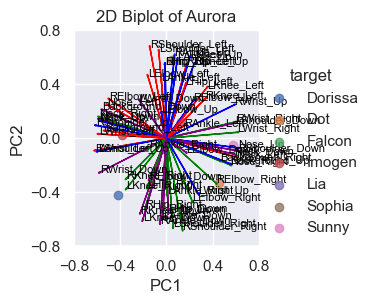

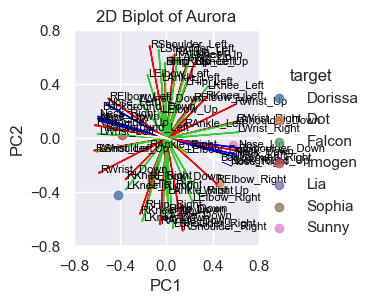

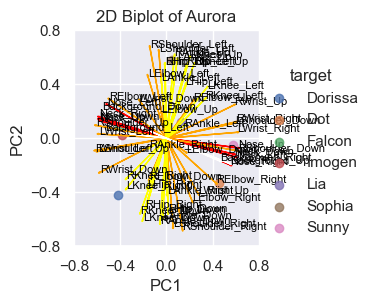

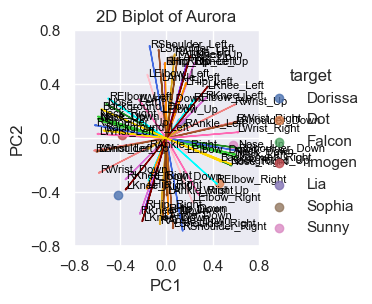

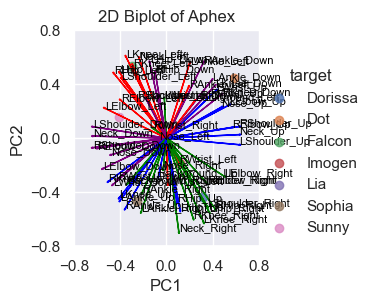

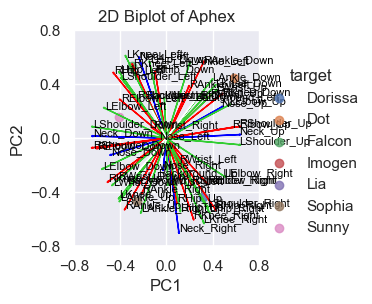

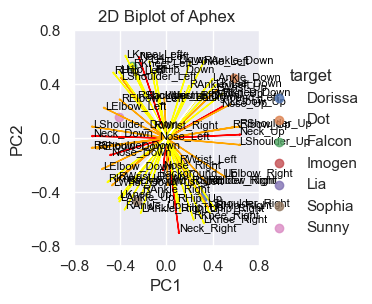

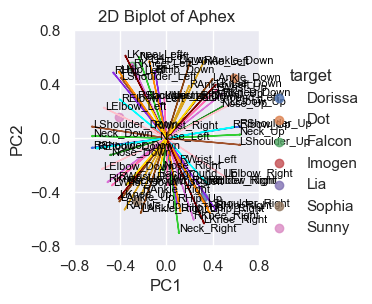

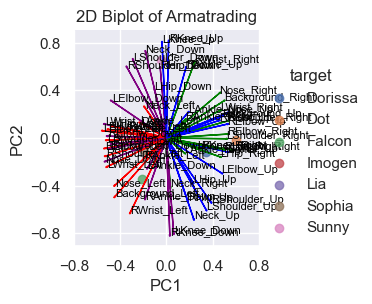

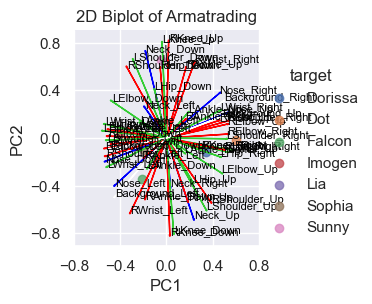

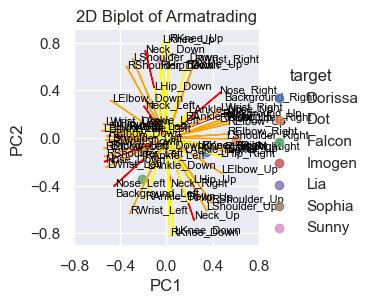

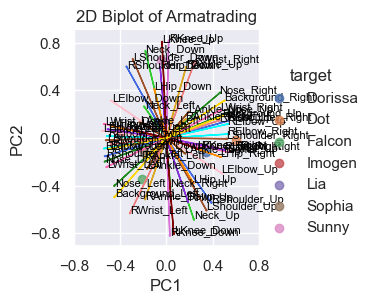

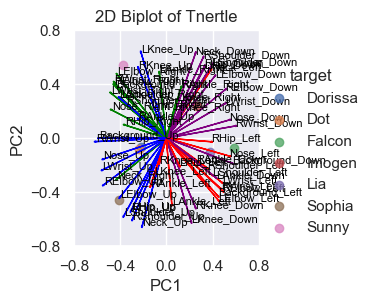

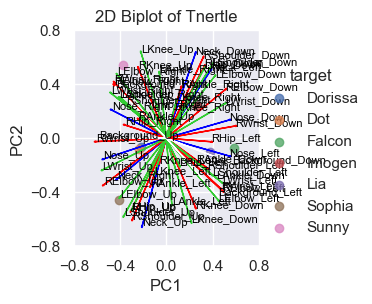

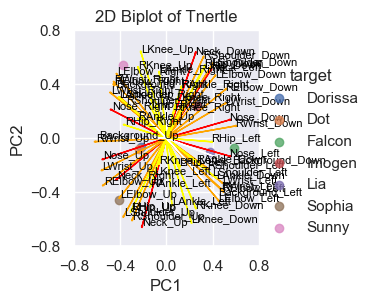

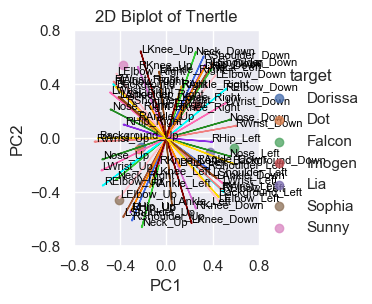

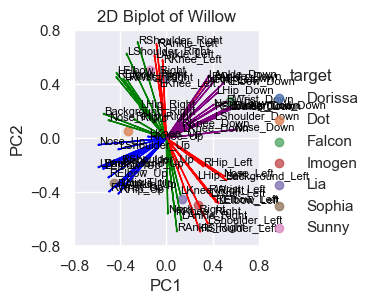

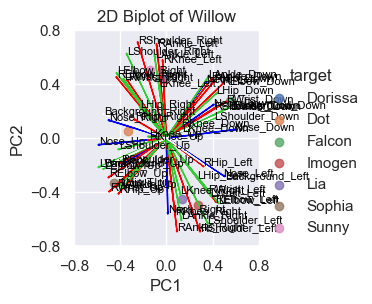

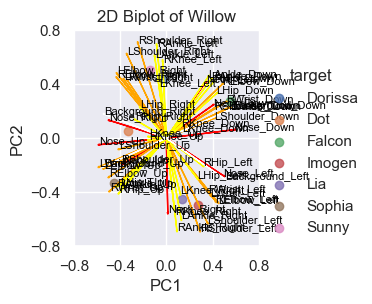

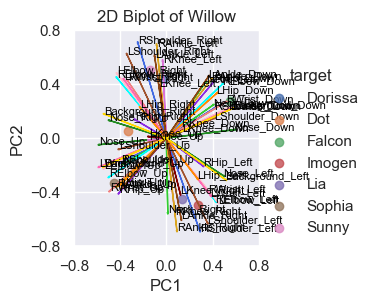

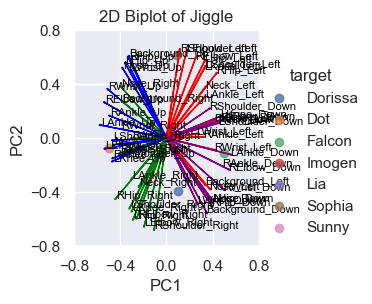

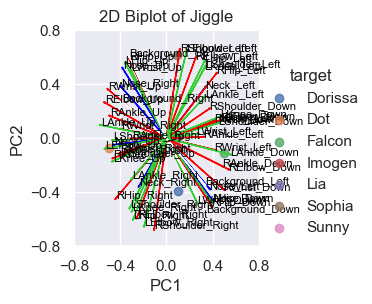

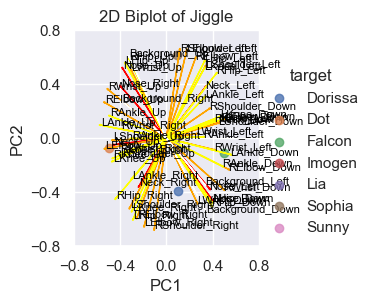

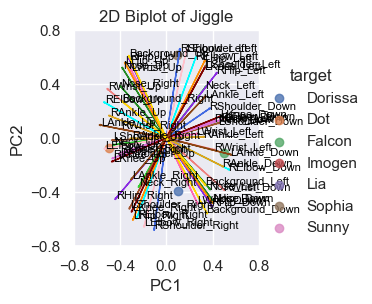

In [135]:
# BIPLOTS
# TODO: BIPLOTS 
def show_pca_biplot(song, color_scheme):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(generate_X(song))

    # Create dataframe
    pca_df = pd.DataFrame(
        data=pca_features, 
        columns=['PC1', 'PC2'])
    pca_df['target'] = ['Dorissa', 'Dot', 'Falcon', 'Imogen', 'Lia', 'Sophia', 'Sunny']

    # Principal components correlation coefficients
    loadings = pca.components_

    # Number of features before PCA
    n_features = pca.n_features_

    # Feature names before PCA
    feature_names = []
    BODY_PARTS = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist",
                   "LShoulder", "LElbow", "LWrist", "RHip", "RKnee",
                   "RAnkle", "LHip", "LKnee", "LAnkle", "Background"]
    for part in BODY_PARTS:
        feature_names.append(part+"_Right")
        feature_names.append(part+"_Left")
        feature_names.append(part+"_Up")
        feature_names.append(part+"_Down")
    
    # Corresponding Arrow Colors
    if color_scheme == 'joints':
        arrow_color = ['forestgreen']*4 + ['limegreen']*4 + ['royalblue']*4 + ['aqua']*4 + ['lightcoral']*4 + ['sienna']*4 + ['pink']*4 +['hotpink']*4 + ['blueviolet']*4 + ['orchid']*4 + ['goldenrod']*4 +['darkorange']*4 + ['maroon']*4 + ['saddlebrown']*4 + ['gold']*4
    if color_scheme == 'hal':
        arrow_color = ['red']*8 + ['orange']*24 + ['yellow']*24 + ['white']*4
    if color_scheme == 'direction':
        arrow_color = ['green', 'red', 'blue', 'purple']*15
    if color_scheme == 'lrc':
        arrow_color = ["blue"]*8 + ['red']*12 + ['limegreen']*12 + ["red"]*12 + ['limegreen']*12 + ["white"]*4
    
    
    pca_df_scaled = pca_df.copy()
 
    scaler_df = pca_df[['PC1', 'PC2']]
    scaler = 1 / (scaler_df.max() - scaler_df.min())

    for index in scaler.index:
        pca_df_scaled[index] *= scaler[index]
    
    sns.set()
 
    xs = loadings[0]
    ys = loadings[1]

    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=pca_df_scaled, 
        hue='target',
        fit_reg=False, 
        height=3, aspect=1
        )
    
    font = {'color':  'black',
        'weight': 'normal',
        'size': 8,
        }

    for i, varnames in enumerate(feature_names):
        plt.arrow(
            0, 0, # coordinates of arrow base
            xs[i]*3, # length of the arrow along x
            ys[i]*3, # length of the arrow along y
            color=arrow_color[i], 
            head_width=0.01,
            )
        plt.text(xs[i]*3, ys[i]*3, varnames, fontdict=font)

    xticks = np.linspace(-0.8, 0.8, num=5)
    yticks = np.linspace(-0.8, 0.8, num=5)
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel('PC1')
    plt.ylabel('PC2')

    plt.title('2D Biplot of ' + song)
    plt.show()
    
for song in song_list:
    show_pca_biplot(song, 'direction')
    show_pca_biplot(song, 'lrc')
    show_pca_biplot(song, 'hal')
    show_pca_biplot(song, 'joints')

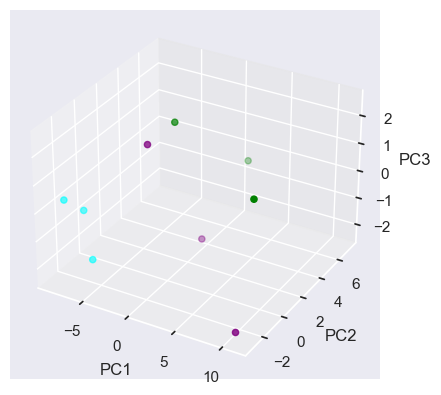

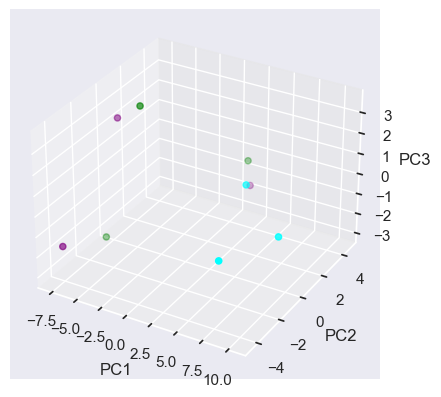

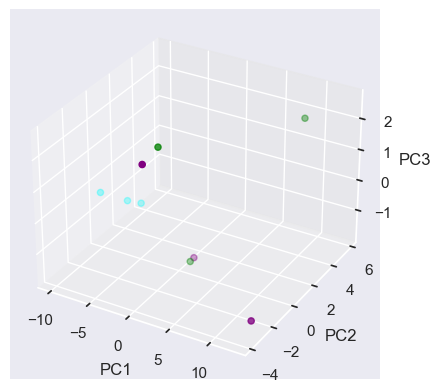

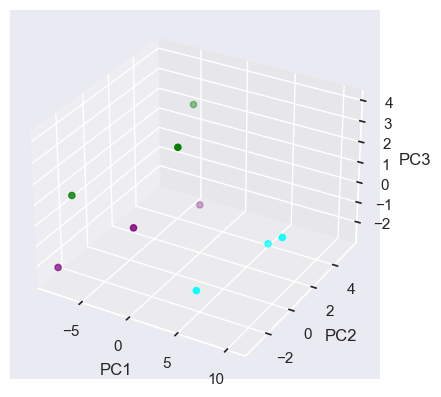

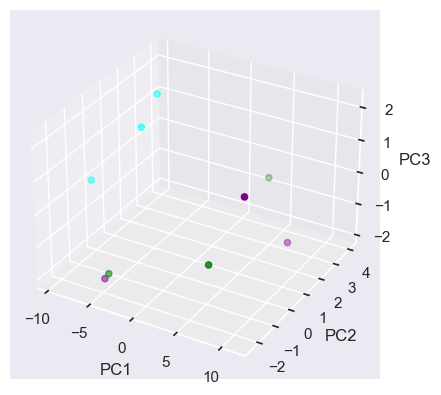

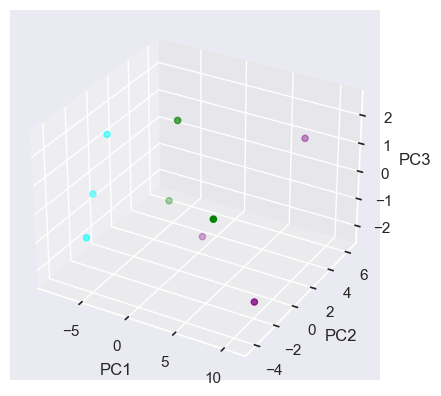

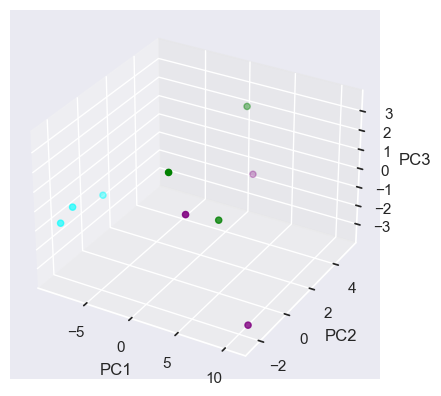

In [113]:
# 3d plot per dancer of all of their vids colored by song (TODO:12 dots per plot) (For now: the 9 w rerecordings)
def generate_X_dancer(dancer):
    dancer_df = df.loc[df['dancer'] == dancer]
    rehearsed_df = dancer_df.loc[dancer_df['song'].isin(song_shortlist)]
    char_vec_set = rehearsed_df['char_vecs_1']
    #char_set_2 = char_vec_set.concat(rehearsed_df['char_vecs_2'])
    #char_set_3 = char_set_2.concat(rehearsed_df['char_vecs_3'])
    char_set_3 = pd.concat([rehearsed_df['char_vecs_1'], rehearsed_df['char_vecs_2'], rehearsed_df['char_vecs_3']])
    
    move_vec_list = []
    for char_vec in char_set_3:
        move_vec_list.append(char_vec)
    X = np.array(move_vec_list)
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled

def show_pca_3plot(dancer):
    X_scaled = generate_X_dancer(dancer)
    pca_3comp = PCA(n_components=3)
    pca_3fit = pca_3comp.fit_transform(X_scaled)
    
    pca_df = pd.DataFrame(data=pca_3fit, columns=['PC1', 'PC2', 'PC3'])
    pca_df['target'] = ['Tnertle', 'Willow', 'Jiggle', 'Tnertle', 'Willow', 'Jiggle', 'Tnertle', 'Willow', 'Jiggle']
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')

    x = pca_df['PC1']
    y = pca_df['PC2']
    z = pca_df['PC3']

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.scatter(x, y, z, c=['green', 'purple', 'aqua', 'green', 'purple', 'aqua', 'green', 'purple', 'aqua'])

    plt.show()

for dancer in dancer_list:
    show_pca_3plot(dancer)

In [ ]:
# 3d Plot of all 60 dances together coloring, every person has their color code by song, shape by person
# 3d plot of all 85 by dancer, by song (2 dif side by side plots)
# 